# Acoustic Absorption calculation using the Finite Element Method and JCAL Model

This notebook explains how to use the **Finite Element Method (FEM)** together with the **Johnson-Champoux-Allard-Lafarge (JCAL)** model to calculate the **acoustic absorption** of a porous material (wool) covered with and without a thin plate (foil) backed by a rigid wall.
The thin plate is considered as a membrane, with tension and mass. It's a 3D model.

---

## 1. Download NGsolve and Import Libraries

The FEM is implemented with the open source library NGsolve

In [ ]:
try:
    import ngsolve
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/ngsolve-install-release-complex.sh" -O "/tmp/ngsolve-install.sh" && bash "/tmp/ngsolve-install.sh"

In [59]:
### Libraries 
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from netgen.geom2d import SplineGeometry

import numpy as np
import matplotlib.pyplot as plt

---

## 2. Define JCAL Model Functions

These functions define the **effective dynamic density** and **effective bulk modulus** of the porous medium according to the **JCAL model**. It uses $e^{-i\omega t}$ convention. The equations have been obtained from [https://doi.org/10.1121/1.415222].

Additionally, the coefficients of the plate are also settled.

In [60]:
# Dynamic density
def rho_eff(omega, rho0, phi, alpha_inf, sigma, eta, Lambda):
    term = 1 - (4j*alpha_inf**2 * eta * rho0 * omega) / (sigma*Lambda*phi)**2
    return alpha_inf * (rho0 - sigma*phi/(1j*omega*alpha_inf) * np.sqrt(term))

# Dynamic Bulk modulus
def K_eff(gamma, P0, phi, eta, Cp, rho0, omega, kappa, Lambda_prime, NPr):
    term = 1 - 8*eta/(1j*Lambda_prime**2*NPr*omega*rho0) * np.sqrt(1 - 1j*rho0*omega*NPr*Lambda_prime/16/eta)
    return  gamma * P0 / (gamma - (gamma - 1) / term)

def properties(omega):
    # Air properties (fluid)
    rhoF  = 1.202 # [Kg/m**3]
    gamma = 1.35 # Heat capacity ratio []
    Cp    = 1006.    # Specific heat capacity [J/(kg*K)] 
    P0    = 101325.  # Pressure [Pa]
    mu    = 1.813e-5  # Dynamic viscosity [Pa s]
    kappa = 25e-3 # Coefficient of thermal conduction [W/(m*K)] # Thermal conductivity
    # Wave propagation coefficients in the fluid
    NPr   = Cp * mu / kappa # Prandtl number
    KF    = gamma * P0 
    kF    = omega * np.sqrt(rhoF/KF)# Wave number in air
    cF    = omega/kF
    
    # Porous material properties
    sigma        = 35160 # Airflow resistivity  [Pa*s/m2] [N*s/m4]
    phi          = 0.951 # Porosity []
    alpha_inf    = 1.02 # Tortuosity []
    Lambda       = 48.7e-6 # Viscous characteristic length [m]
    Lambda_prime = 121.3e-6 # Thermal characteristic length [m]
    # Wave propagation coefficients in the porous material
    rhoP  = rho_eff(omega, rhoF, phi, alpha_inf, sigma, mu, Lambda)
    KP    = K_eff(gamma, P0, phi, mu, Cp, rhoF, omega, kappa, Lambda_prime, NPr)
    kP    = omega * np.sqrt(rhoP/KP)# Wave number in Porous
    cP = omega/kP
    
    # Plate properties
    rhoPlate =  2800.*18e-6 + 20e-3 # Surface density [Kg/m**2]
    sPlate   = 0 # Damping coefficient
    rPlate   = 0 # Elastic coefficient
    tauPlate = 0 # N/m # Membrane tension
    
    return kF, kP, rhoF, rhoP, KF, KP, rhoPlate, sPlate, rPlate, tauPlate

## 3. Setting up the geometry and its boundary labelling

In [61]:
### Geometry
L = 0.5 # Lenght of the squared pannel L x L
R = 1*L # Radious of the air sphere
a = 20e-3 # Thickness of the wool pannel
T = 0.5 # Thickness of the PML

sphere = Sphere((0,0,0), R)
spherepml = Sphere((0,0,0), R+T) 
dif = Box((-2*(R+T),-2*(R+T),-2*(R+T)), (2*(R+T),2*(R+T),0))
pmlR = spherepml - sphere - dif
wool = Box((-L/2,-L/2,0), (L/2,L/2,a))
air = sphere - dif - wool

# Boundary conditions

pmlR.mat("pmlR")
pmlR.faces.name="pmlOut"
pmlR.faces.Min(Z).name = "floor_pml"
pmlR.maxh = 0.3


air.faces.name="air"
air.faces.Max(Z).name = "speaker"
air.faces.Min(Z).name = "floor_air"
air.mat("air")
air.maxh  = 0.1


wool.faces.name="wall_wool"
wool.faces.Max(Z).name = "interface"
wool.faces.Min(Z).name = "floor_wool"

wool.mat("wool")
wool.maxh = 0.05


## Each face can be colored
pmlR.faces.col = (0, 0, 1)
air.faces.col = (0, 1, 0)
wool.faces.col = (1, 0, 0)
geo = Glue([air, wool, pmlR])
Draw(geo, clipping={ "x" : 10}, height="3vh", euler_angles=[-65,5,55])

WebGuiWidget(layout=Layout(height='3vh', width='100%'), value={'ngsolve_version': 'Netgen x.x', 'mesh_dim': 3,…

BaseWebGuiScene

## 4. Build the mesh and plot it

In [62]:
geoM = OCCGeometry(geo, dim=3)
mesh = Mesh(geoM.GenerateMesh())

Draw(mesh, clipping={ "y" : 90}, height="3vh", euler_angles=[-77,17,-32])


WebGuiWidget(layout=Layout(height='3vh', width='100%'), value={'gui_settings': {'camera': {'euler_angles': [-7…

BaseWebGuiScene

Print names for subdomains and boundaries

In [63]:
print(mesh.GetBoundaries())
print(mesh.GetMaterials())

('speaker', 'floor_air', 'wall_wool', 'wall_wool', 'wall_wool', 'wall_wool', 'interface', 'floor_wool', 'pmlOut', 'floor_pml')
('air', 'wool', 'pmlR')


## 5. Initialization of the parameters of the variational formulation 
(only real values can be stored in a Parameter object in NGSolve)

In [64]:
omega = 100.0*2.0*np.pi # initial frequency [rad/s]

# Properties
kF, kA, rhoF, rhoA, KF, KA, rhoPlate, sPlate, rPlate, tauPlate = properties(omega)

# Define parameters which dependes on the frequency
omega2 = Parameter(omega**2) # Frequency squared
wavenumber_F = Parameter(kF) # Wavenumber of air
bulk_modulus_F = Parameter(KF) # Bulk modulus of air
bulk_modulus_A_real = Parameter(KA.real)  # Bulk modulus of wool, real. part
bulk_modulus_A_imag = Parameter(KA.imag) # Bulk modulus of wool, imag. part
mass_F = Parameter(omega**2*rhoF) # Inertia coefficient of air
mass_A_real = Parameter(omega**2*rhoA.real) # Inertia coefficient of wool, real. part
mass_A_imag = Parameter(omega**2*rhoA.imag) # Inertia coefficient of wool, imag. part
mass_Plate = Parameter(omega**2*rhoPlate) # Inertia coefficient of plate
damping_Plate = Parameter(omega*sPlate) # Damping coefficient of plate
elastic_Plate = Parameter(rPlate) # Elastic coefficient of plate
rho_A_real = Parameter(rhoA.real)# density of wool, real part
rho_A_imag = Parameter(rhoA.imag)# density of wool, imag part
wavenumber_A_real = Parameter(kA.real)  # wavenumber of wool, real. part
wavenumber_A_imag = Parameter(kA.imag)  # wavenumber of wool, imag. part

## 6. PML definition 

In [65]:
mesh.SetPML(pml.Radial(rad=R, alpha=20j/kF, origin=(0,0,0)), "pmlR") 

## 7. Setting up the finite element discretization, the variational formulation and the incident planewave

In [66]:
orderFE = 4 # Order of the finite element

# Finite element spaces
Vf = Compress(H1(mesh, order=orderFE, complex=True, definedon=mesh.Materials("air|pmlR"),  dirichlet = "pmlOut")) # Pressure in the air (order=3)
Va = Compress(H1(mesh, order=orderFE, complex=True, definedon=mesh.Materials("wool"))) # Pressure in the porous (order=3)
Vp = Compress(H1(mesh, order=orderFE, complex=True, definedon=mesh.Boundaries("interface"))) # normal displacement on the plate (order-1)

# FEM discrete space
V = Vf * Va * Vp

# Trial and test functions
(pf, pa, up), (qf, qa, vp) = V.TnT()

# Normal vector outward to the boundary
normal = specialcf.normal(mesh.dim)
# The coefficient function associated with the normals is only defined in the fluid domain to ensure that it is exterior to the fluid domain
# order of the subdomains: ('air', 'wool', 'pmlR')
normal_F = CoefficientFunction([normal, None, None])
normal_F_exterior = BoundaryFromVolumeCF(normal_F)

# Define the differential on the integration on the volumes
dF = dx(mesh.Materials("air|pmlR")) # fluid domain
dA = dx(mesh.Materials("wool")) # porous domain

# Define the differential on the integration on the interface boundary
dI = ds(mesh.Boundaries("interface")) # interface boundary
#dW = ds(mesh.Boundaries("wall")) # wall boundary
dW = ds(mesh.Boundaries("wall_wool")) # wall boundary

# Variational formulation: Bilinear form
a_bilinear = BilinearForm(V, symmetric=False)
# Contribution in the air
a_bilinear += grad(pf)*grad(qf)/rhoF * dF - wavenumber_F**2/rhoF* pf*qf * dF - omega2*up*qf * dI
# Contribution in the porous material
a_bilinear += grad(pa)*grad(qa)/(rho_A_real+1j*rho_A_imag) * dA - (wavenumber_A_real+1j*wavenumber_A_imag)**2/(rho_A_real+1j*rho_A_imag) * pa*qa * dA + omega2*up*qa * dI
# Contribution in the plate (membrane + mass + jump on the pressure field)
a_bilinear += tauPlate*(grad(up).Trace()*grad(vp).Trace())*dI - (- mass_Plate - 1j*damping_Plate + elastic_Plate)*(up*vp)*dI - (pa - pf)*vp*dI

# Incident plane wave and null vector
u_inc = CF((0., 0., 0.)) # Incident displacement vector to the plate interface in the fluid domain
u_diffuse = CF((0., 0., 0.)) # Diffuse displacement vector to the plate interface in the fluid domain
p_inc = CF(0.) # Incident Pressure field in the fluid domain
p_diffuse = CF(0.) # Diffuse Pressure field in the fluid domain

# Generation of the diffuse field with N randomplane waves which satisfies the rigid boundary condition at z=0
np.random.seed(123) # Fix the seed for reproducibility
N = 100 # Number of random plane waves
for k in range(0,N):
    # Random values for the wavenumber vector kvec
    theta = np.random.rand()*np.pi*2 - np.pi # Polar angle in the plane XY in [-pi, pi)
    phi   = np.random.rand()*np.pi/2 # Azimuthal angle with respect to the Z axis in [0,pi/2)
    shift = np.random.rand()*np.pi*2 # Phase shift of the complex argument in [0,2*pi)
    A_dot_xy   = cos(theta)*sin(phi)*x+sin(theta)*sin(phi)*y # Dot product of the unit amplitude vector with the position vector in the xy plane
    A_dot_xyz  = cos(theta)*sin(phi)*x+sin(theta)*sin(phi)*y+cos(phi)*z # Dot product of the unit amplitude vector with the position vector in the xyz space
    p_inc +=     2.*exp(-1j*wavenumber_F*A_dot_xy+ 1j*shift)*cos(wavenumber_F*cos(phi)*z) # Incident pressure field in the fluid domain
    p_diffuse +=    exp(-1j*wavenumber_F*A_dot_xyz  + 1j*shift) # Diffuse pressure field in the fluid domain
    
    # Incident displacement field in the fluid domain
    u_inc     += -2*wavenumber_F/mass_F * (1j*cos(theta)*sin(phi)*exp(-1j*wavenumber_F*A_dot_xy+ 1j*shift)*cos(wavenumber_F*cos(phi)*z), 
                                           1j*sin(theta)*sin(phi)*exp(-1j*wavenumber_F*A_dot_xy+ 1j*shift)*cos(wavenumber_F*cos(phi)*z),
                                                         cos(phi)*exp(-1j*wavenumber_F*A_dot_xy+ 1j*shift)*sin(wavenumber_F*cos(phi)*z))
    # Diffuse displacement field in the fluid domain
    u_diffuse += -1j*wavenumber_F/mass_F * (  cos(theta)*sin(phi)*exp(-1j*wavenumber_F*A_dot_xyz+ 1j*shift),
                                              sin(theta)*sin(phi)*exp(-1j*wavenumber_F*A_dot_xyz+ 1j*shift),
                                                         cos(phi)*exp(-1j*wavenumber_F*A_dot_xyz+ 1j*shift))

# Linear form
f = LinearForm(V)
# Source term in the fluid wall boundaries associated with the boundaries of the fluid domain
f += -omega2*(u_inc*normal_F_exterior)*qf * dW ##TODO: uncommment this line in the spherical case
# Source term on the interface boundary due to the translation of the incident pressure field p_inc
f += -p_inc*vp*dI - omega2*(u_inc*normal_F_exterior)*qf * dI

# Functional space for the displacement field
Q = Compress(HDiv(mesh, order=orderFE, complex=True, definedon=mesh.Materials("air"),  dirichlet = "wool_wall|floor_air"))

## 8. Loop in frequency to compute the FRF (Frequency Response Function) of the absorption coefficient 

In [67]:
# Frequency data
NFreq   = 15   # frequency samples
MinFreq = 200  # Min frequency [Hz]
MaxFreq = 2000 # Max frequency [Hz]
omega_vec = np.linspace(MinFreq*2*np.pi, MaxFreq*2*np.pi, NFreq) # Angular frequency [rad/s]

# Allocate memory for the results
alpha_vec = np.zeros(NFreq)
alphaTMM_vec = np.zeros(NFreq)
Z_vec = np.zeros(NFreq, dtype=complex)
ZTMM_vec = np.zeros(NFreq, dtype=complex)
tau_vec = np.zeros(NFreq)
reflection_vec = np.zeros(NFreq, dtype=complex)
reflectionTMM_vec = np.zeros(NFreq, dtype=complex)

# Loop over the frequencies
for i, omega in enumerate(omega_vec):

    # Properties
    kF, kA, rhoF, rhoA, KF, KA, rhoPlate, sPlate, rPlate, tauPlate = properties(omega)

    # Define parameters which dependes on the frequency
    omega2.Set(omega**2) # Frequency squared
    wavenumber_F.Set(kF) # Wavenumber of air
    bulk_modulus_F.Set(KF) # Bulk modulus of air
    bulk_modulus_A_real.Set(KA.real)  # Bulk modulus of wool, real. part
    bulk_modulus_A_imag.Set(KA.imag) # Bulk modulus of wool, imag. part
    mass_F.Set(omega**2*rhoF) # Inertia coefficient of air
    mass_A_real.Set(omega**2*rhoA.real) # Inertia coefficient of wool, real. part
    mass_A_imag.Set(omega**2*rhoA.imag) # Inertia coefficient of wool, imag. part
    mass_Plate.Set(omega**2*rhoPlate) # Inertia coefficient of plate
    damping_Plate.Set(omega*sPlate) # Damping coefficient of plate
    elastic_Plate.Set(rPlate) # Elastic coefficient of plate
    rho_A_real.Set(rhoA.real) # density of wool, real part
    rho_A_imag.Set(rhoA.imag) # density of wool, imag part
    wavenumber_A_real.Set(kA.real)  # wavenumber of wool, real. part
    wavenumber_A_imag.Set(kA.imag)  # wavenumber of wool, imag. part

    # Update the PML coefficients depending on the fluid wavenumber
    mesh.SetPML(pml.Radial(rad=R, alpha=20j/kF, origin=(0,0,0)), "pmlR") 
    V.Update() # Update the discrete space

    # Assembly the FEM matrices and the right-hand side
    a_bilinear.Assemble()
    f.Assemble()

    # Allocate the solution vector
    gfu = GridFunction(V)

    # Solve the linear system
    c = Preconditioner(a_bilinear,"direct") # sparse direct solver (UMFPACK) ## bddc más rápido
    solvers.BVP(bf=a_bilinear, lf=f, gf=gfu, pre=c, print=False)

    # Get the scattered fields
    pf, pa, up = gfu.components

    # Computing incident and reflected effective acoustic power (exterior normal vector to the fluid domain on the interface = -e_z)
    # Incident field including the reflections from the rigid floor
    pfI = GridFunction(Vf)
    pfI.Set(p_inc, definedon=mesh.Materials("air")) # Incident pressure field in the fluid domain

    # Incident diffuse field without including the reflections from the rigid floor
    pfD = GridFunction(Vf)
    pfD.Set(p_diffuse, definedon=mesh.Materials("air"))

    # Incident displacement field including the reflections from the rigid floor
    upD = GridFunction(Q)
    upD.Set(u_diffuse, definedon=mesh.Materials("air"))

    # Computation of the effective acoustic power only on the interface
    Power_inc = omega*0.5*np.imag(Integrate(InnerProduct(pfD, -upD*normal_F_exterior), mesh.Boundaries("interface"))) # Incoming incident effective acoustic power 
    Power_ref = omega*0.5*np.imag(Integrate(InnerProduct(pf+pfI-pfD, up-upD*normal_F_exterior), mesh.Boundaries("interface"))) # Outgoing reflected effective acoustic power 
    
    # Absorption coefficient
    reflection_vec[i] = Power_ref/Power_inc # Reflection coefficient in terms of power = |P_ref|^2/|P_inc|^2 in terms of pressure or displacement computations
    alpha_vec[i] = 1 - np.abs(reflection_vec[i])
    print(f"Frequency: {omega/2/np.pi}: Incident power = {Power_inc}, Reflected power = {Power_ref}, Absorption coefficient = {alpha_vec[i]}")
    
    # Computation with the TMM method: the origin of coordinates is located on the rigid floor (z=0) and the plate is located at z=a
    # The computed amplitudes correspond to the pressure field
    ZPlate=(-rhoPlate*omega**2 - 1j*omega*sPlate + rPlate)
    A =  np.array([[1, 0, 0, 0],
                   [-1j*kF/omega**2/rhoF*np.exp(-1j*kF*a), 1j*kF/omega**2/rhoF*np.exp(1j*kF*a), 1j*kA/omega**2/rhoA*np.exp(-1j*kA*a), -1j*kA/omega**2/rhoA*np.exp(1j*kA*a)],
                   [(1 + ZPlate*(-1j*kF)/(omega**2*rhoF))*np.exp(-1j*kF*a), (1 + ZPlate*(1j*kF)/(omega**2*rhoF))*np.exp(1j*kF*a), -np.exp(-1j*kA*a) , -np.exp(1j*kA*a)],
                   [0, 0, -1j*kA/omega**2/rhoA, 1j*kA/omega**2/rhoA]
                   ])
    
    c = np.array([exp(1j*shift),0.,0.,0.]) 
    b = np.linalg.solve(A, c) 
    # Absorption coefficient
    alphaTMM_vec[i] = 1 - (np.abs(b[1]/b[0])) ** 2
    print(f"TMM: Frequency: {omega/2/np.pi}: Absorption coefficient = {alphaTMM_vec[i]}")
    # Reflection coefficient
    reflectionTMM_vec[i] = b[1]
    # Surface impedance
    ZTMM_vec[i] = (b[0] + b[1]) / (b[0] - b[1]) * np.sqrt(rhoF*KF)

Frequency: 200.0: Incident power = 0.001638024328718415, Reflected power = 0.0016534269042856695, Absorption coefficient = -0.009403142125065767
TMM: Frequency: 200.0: Absorption coefficient = 0.02319533194342771
Frequency: 328.5714285714286: Incident power = 0.004216546406767562, Reflected power = 0.0044552000125382555, Absorption coefficient = -0.05659930728798668
TMM: Frequency: 328.5714285714286: Absorption coefficient = 0.06513459877364203
Frequency: 457.14285714285717: Incident power = 0.006936747508011214, Reflected power = 0.007100694133222712, Absorption coefficient = -0.02363450954819335
TMM: Frequency: 457.14285714285717: Absorption coefficient = 0.13365990335264344
Frequency: 585.7142857142857: Incident power = 0.009341856913021716, Reflected power = 0.007863936717145107, Absorption coefficient = 0.1582041139825766
TMM: Frequency: 585.7142857142857: Absorption coefficient = 0.23506039055888817
Frequency: 714.2857142857142: Incident power = 0.011308086764380961, Reflected po

## 9. Plot the diffusive incident field in the fluid domain

In [68]:
clipping = { "function" : True,  "pnt" : (0.,0.,0.), "vec" : (1,0,0) }
scene = Draw(pfI, mesh, height="3vh", animate_complex=True, clipping=clipping, euler_angles=[-65,5,55])

WebGuiWidget(layout=Layout(height='3vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'spe…

## 10. Plot the reflected pressure field in the fluid domain

In [69]:
clipping = { "function" : True,  "pnt" : (0.,0.,0.), "vec" : (1,0,0) }
scene = Draw(pf, mesh, height="3vh", animate_complex=True, clipping=clipping, euler_angles=[-65,5,55])

WebGuiWidget(layout=Layout(height='3vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'spe…

## 11. Plot the absorption coefficient

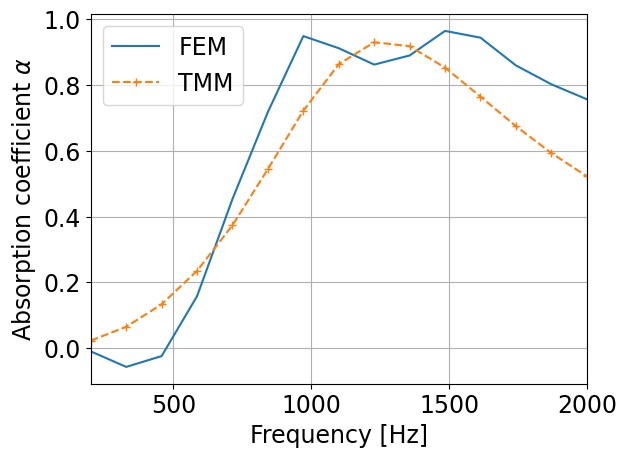

In [70]:
size = 17
freq_vec=omega_vec/2/np.pi
plt.plot(freq_vec, alpha_vec, label = "FEM")
plt.plot(freq_vec, alphaTMM_vec, '--+', label = "TMM")
plt.xlabel("Frequency [Hz]", fontsize=size)
plt.ylabel(r"Absorption coefficient $\alpha$", fontsize=size)
#plt.ylim(0., 1.0)
#plt.xscale("log")
plt.tick_params(axis='both', labelsize=size)
plt.xlim(freq_vec[0], freq_vec[-1])
plt.grid()
plt.legend(fontsize=size)
plt.show()

## 12. Plot the reflection coefficient

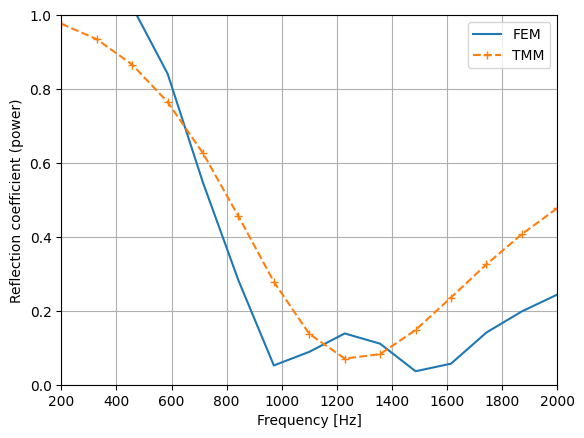

In [71]:
plt.plot(freq_vec, np.abs(reflection_vec),  label = "FEM")
plt.plot(freq_vec, np.abs(reflectionTMM_vec)**2, '--+', label = "TMM")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Reflection coefficient (power)")
plt.ylim(0, 1.)
plt.xlim(freq_vec[0], freq_vec[-1])
plt.grid()
plt.legend()
plt.show()
